In [22]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Set the GROQ_API_KEY from the environment
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Check if the API key is loaded
if not os.environ.get("GROQ_API_KEY"):
    raise ValueError("GROQ_API_KEY not found. Please set it in your .env file.")

print("✅ API Key loaded successfully.")


✅ API Key loaded successfully.


In [23]:
# Install the required package directly from the notebook
!pip install -U duckduckgo-search

from typing import TypedDict, Annotated, List
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph.message import add_messages

# Initialize the search tool
search_tool = DuckDuckGoSearchRun()
print(f"✅ Search tool initialized. Testing with 'LangGraph':\n\n{search_tool.run('LangGraph')[:200]}...")

# Define the state for our graph
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        topic: The user-provided topic for the blog.
        research_material: The raw data gathered by the research agent.
        draft: The blog post draft written by the drafting agent.
        review_feedback: Feedback from the review agent on the draft.
        revision_notes: Notes from the human for required changes.
        final_blog: The final, human-approved blog post.
    """
    topic: str
    research_material: str
    draft: str
    review_feedback: str
    revision_notes: str
    final_blog: str


/home/nikhil/learning/agentic_ai/workspace/venv/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=19473) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


/home/nikhil/learning/agentic_ai/workspace/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


✅ Search tool initialized. Testing with 'LangGraph':

May 20, 2025 · If you are new to LangGraph and wish to learn about it, then this beginner's guide and hands-on tutorial is the best free content for you. Jun 17, 2025 · What is LangGraph and How Does ...


In [24]:
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
import time

# Initialize the LLM
llm = ChatGroq(model="llama3-70b-8192", temperature=0)

def research_agent(state: GraphState):
    """
    Node for the research agent. It searches the web for the given topic.
    """
    print("--- NODE: Research Agent ---")
    topic = state['topic']
    
    system_prompt = SystemMessage(content="""
    You are a world-class research assistant. Your goal is to find the most relevant,
    accurate, and up-to-date information on a given topic using the provided search tool.
    Synthesize the findings from your search into a coherent, easy-to-read summary.
    Focus on key facts, figures, and main points.
    """)
    
    search_results = search_tool.run(topic)
    
    task_prompt = HumanMessage(
        content=f"Please research the following topic: {topic}\n\nHere are the search results:\n{search_results}"
    )
    
    response = llm.invoke([system_prompt, task_prompt])
    
    print(f"✅ Research complete for topic: {topic}")
    return {"research_material": response.content}


def draft_agent(state: GraphState):
    """
    Node for the drafting agent. It writes a blog post based on the research.
    """
    print("--- NODE: Draft Agent ---")
    topic = state['topic']
    research_material = state['research_material']
    revision_notes = state.get('revision_notes')

    system_prompt = SystemMessage(content="""
    You are an expert blog post writer. Your task is to write a compelling,
    well-structured, and engaging blog post based on the provided research material.
    The blog post should have a clear introduction, body, and conclusion.
    Use markdown for formatting, including headings, bold text, and lists where appropriate.
    Aim for a comprehensive blog post of approximately 2000 characters.
    """)

    if revision_notes:
        print("📝 Redrafting based on human feedback...")
        task_prompt = HumanMessage(content=f"""
        Please redraft the blog post on the topic: '{topic}'.
        
        Here is the original research material:
        {research_material}
        
        Please incorporate the following revision notes from the user:
        '{revision_notes}'
        """)
    else:
        task_prompt = HumanMessage(content=f"""
        Please write a blog post on the topic: '{topic}'.
        
        Use the following research material as a basis for the post:
        {research_material}
        """)

    response = llm.invoke([system_prompt, task_prompt])
    
    print("✅ Blog draft completed.")
    return {"draft": response.content}


def review_agent(state: GraphState):
    """
    Node for the review agent. It critiques the draft for quality and accuracy.
    """
    print("--- NODE: Review Agent ---")
    draft = state['draft']
    
    system_prompt = SystemMessage(content="""
    You are a meticulous editor and reviewer. Your job is to review a blog post draft.
    Provide constructive feedback, pointing out any potential issues with clarity,
    accuracy, tone, or engagement. Be specific in your feedback. If the draft is good,
    say so.
    """)
    
    task_prompt = HumanMessage(content=f"Please review the following blog post draft:\n\n{draft}")
    
    response = llm.invoke([system_prompt, task_prompt])
    
    print("✅ Review completed.")
    return {"review_feedback": response.content}

def print_boxed(title, content):
    """Helper function to print content in a formatted box."""
    box_width = 80
    print("\n" + "╔" + "═" * (box_width - 2) + "╗")
    title_line = f"║ 📄 {title.upper()} "
    print(title_line + " " * (box_width - len(title_line) - 1) + "║")
    print("╠" + "═" * (box_width - 2) + "╣")
    
    lines = content.split('\n')
    for line in lines:
        # Simple word wrapping logic
        temp_line = line
        while len(temp_line) > box_width - 4:
            split_pos = temp_line.rfind(' ', 0, box_width - 4)
            if split_pos == -1:
                split_pos = box_width - 4
            print(f"║ {temp_line[:split_pos]:<{box_width - 4}} ║")
            temp_line = temp_line[split_pos:].lstrip()
        print(f"║ {temp_line:<{box_width - 4}} ║")

    print("╚" + "═" * (box_width - 2) + "╝" + "\n")


def human_approval_node(state: GraphState):
    """
    Node for the human-in-the-loop. Pauses for human approval or revisions.
    """
    print("--- NODE: Human-in-the-Loop (Waiting for your input) ---")
    draft = state['draft']
    review_feedback = state['review_feedback']

    # Use the helper function to print the draft and review in a structured way
    print_boxed("Blog Draft for Your Review", draft)
    print_boxed("Reviewer Agent's Feedback", review_feedback)

    while True:
        feedback = input("🤔 Approve the draft? (yes/no): ").strip().lower()
        if feedback in ["yes", "y"]:
            print("✅ Draft approved by human.")
            return {"final_blog": draft, "revision_notes": None}
        elif feedback in ["no", "n"]:
            revision_notes = input("Please provide your revision notes: ").strip()
            if revision_notes:
                print("📝 Revision notes received. Sending back to drafter.")
                return {"revision_notes": revision_notes, "final_blog": None}
            else:
                print("Please provide some notes for the revision.")
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")


In [25]:
END = "end"

def should_redraft(state: GraphState):
    """
    Determines if a redraft is needed based on human feedback.
    """
    print("--- CONDITIONAL EDGE: Checking for revisions ---")
    if state.get("revision_notes"):
        print("Decision: Revisions needed. Looping back to draft agent.")
        return "draft_agent"
    else:
        print("Decision: No revisions. Ending the process.")
        return END


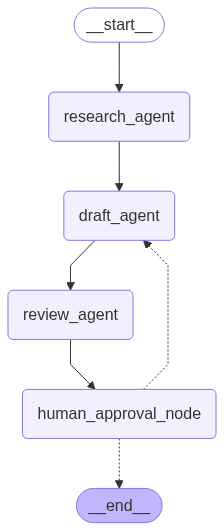

In [26]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

# Initialize a new state graph
workflow = StateGraph(GraphState)

# Add the nodes to the graph
workflow.add_node("research_agent", research_agent)
workflow.add_node("draft_agent", draft_agent)
workflow.add_node("review_agent", review_agent)
workflow.add_node("human_approval_node", human_approval_node)

# Set the entry point
workflow.set_entry_point("research_agent")

# Add the standard edges
workflow.add_edge("research_agent", "draft_agent")
workflow.add_edge("draft_agent", "review_agent")
workflow.add_edge("review_agent", "human_approval_node")

# Add the conditional edge for the human-in-the-loop
workflow.add_conditional_edges(
    "human_approval_node",
    should_redraft,
    {
        "draft_agent": "draft_agent",
        END: END
    }
)

# Compile the graph into a runnable app
app = workflow.compile()

# Display the graph structure to verify it
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}. Please ensure pygraphviz and its dependencies are installed.")



In [27]:
import json

# Get the initial topic from the user
topic = input("Hello! What topic should the blog be about today? ").strip()

# The config is important to make the stream interactive
config = {"recursion_limit": 100}

# Prepare the initial state
initial_state = {"topic": topic}

# Stream the graph execution
# The `stream` method will automatically execute the graph, pausing for input
# at the `human_approval_node`. The print statements within each node
# (like the draft and review) will be displayed in the console as they execute.
final_state = None
for event in app.stream(initial_state, config=config):
    # The stream yields a dictionary with the node name and its output state.
    for node_name, state_update in event.items():
        print(f"\n--- Event: Finished '{node_name}' ---")
        # To see the full state at each step for debugging, you can uncomment the next line
        # print(json.dumps(state_update, indent=2, ensure_ascii=False))
    final_state = list(event.values())[-1] # Keep track of the last state

print("\n" + "🎉"*20)
print("Blog Generation Complete!")
print("🎉"*20 + "\n")

# Safely print the final approved blog post in a formatted box
if final_state and final_state.get("final_blog"):
    final_blog_content = final_state['final_blog']
    box_width = 80
    print("Here is your final, approved blog post:")
    print("╔" + "═" * (box_width - 2) + "╗")
    
    lines = final_blog_content.split('\n')
    for line in lines:
        # Simple word wrapping logic
        temp_line = line
        while len(temp_line) > box_width - 4:
            split_pos = temp_line.rfind(' ', 0, box_width - 4)
            if split_pos == -1:
                split_pos = box_width - 4
            print(f"║ {temp_line[:split_pos]:<{box_width - 4}} ║")
            temp_line = temp_line[split_pos:].lstrip()
        print(f"║ {temp_line:<{box_width - 4}} ║")
        
    print("╚" + "═" * (box_width - 2) + "╝")
else:
    print("The process was stopped or did not result in a final blog.")


--- NODE: Research Agent ---


/home/nikhil/learning/agentic_ai/workspace/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


✅ Research complete for topic: music

--- Event: Finished 'research_agent' ---
--- NODE: Draft Agent ---
✅ Blog draft completed.

--- Event: Finished 'draft_agent' ---
--- NODE: Review Agent ---
✅ Review completed.

--- Event: Finished 'review_agent' ---
--- NODE: Human-in-the-Loop (Waiting for your input) ---

╔══════════════════════════════════════════════════════════════════════════════╗
║ 📄 BLOG DRAFT FOR YOUR REVIEW                                                 ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ **The Universal Language of Music: A World of Emotion and Connection**       ║
║ =================================================================            ║
║                                                                              ║
║ Music is a phenomenon that has been woven into the fabric of human history,  ║
║ transcending cultures, generations, and geographical boundaries. It is a     ║
║ language that speaks directly to our 